In [1]:
pip install dezero

In [2]:
import numpy as np
import dezero
import dezero.functions as F
import dezero.layers as L
from dezero import optimizers
from dezero import DataLoader
from dezero.models import Model
from dezero.transforms import Compose, Normalize, ToFloat

Define the network

In [3]:
class Net(Model):
  def __init__(self):
    super().__init__()
    self.conv1 = L.Conv2d(6, kernel_size=3, stride=1, pad=1)
    self.conv2 = L.Conv2d(16, kernel_size=3, stride=1, pad=1)
    self.linear1 = L.Linear(120)
    self.linear2 = L.Linear(84)
    self.linear3 = L.Linear(10)
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.pooling(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.flatten(x)
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return x

In [4]:
max_epoch = 15
batch_size = 100

#maximum 1, minimum 0
transform = Compose([ToFloat(), Normalize(0., 255.)])

#Load, MNIST
train_set = dezero.datasets.MNIST(train=True, transform= transform)
test_set = dezero.datasets.MNIST(train=False, transform= transform)

train_loader = DataLoader(train_set, batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size)

train_loader.to_gpu()
test_loader.to_gpu()

net = Net()
net.to_gpu()
optimizer = optimizers.SGD().setup(net)

#lists to record accuracies and losses.
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

Downloading: train-images-idx3-ubyte.gz
[##############################] 100.00% Done
Downloading: train-labels-idx1-ubyte.gz
[##############################] 100.00% Done
Downloading: t10k-images-idx3-ubyte.gz
[##############################] 100.00% Done
Downloading: t10k-labels-idx1-ubyte.gz
[##############################] 100.00% Done


In [5]:
def test_score(net, test_loader, test_set):
  """
  return test_loss and accurcy, test_mode
  """
  #initialize tmp_loss and tmp accuracy for test_loader.
  tmp_loss, tmp_acc = 0.0, 0.0
  
  for x, t in test_loader:
    y = net(x)
    loss = F.softmax_cross_entropy(y, t)
    tmp_loss += float(loss.data) * len(t)
    tmp_acc += float(F.accuracy(y, t).data) * len(t)

  return tmp_loss / (len(test_set)), tmp_acc / len(test_set) 

training MNIST

In [6]:
for epoch in range(max_epoch):
  #initialize tmp_loss and tmp accuracy for test_loader.
  tmp_loss, tmp_acc = 0.0, 0.0

  for x, t in train_loader:
    y = net(x)
    loss = F.softmax_cross_entropy(y, t)
    #update model
    net.cleargrads()
    loss.backward()
    optimizer.update()

    tmp_loss += float(loss.data) * len(t)
    tmp_acc += float(F.accuracy(y, t).data) * len(t)

  train_losses.append(tmp_loss / (len(train_set)))
  train_accuracies.append(tmp_acc / len(train_set))

  #calc_test_scores
  test_loss, test_acc = test_score(net, test_loader, test_set)

  test_losses.append(test_loss)
  test_accuracies.append(test_acc)

  print("Epoch:", epoch + 1)
  print("train_loss:{:.3f},'test loss: {:.3f}".format(
      train_losses[-1], test_losses[-1]))
  print("train_acc:{:.3f},'test acc: {:.3f}".format(
      train_accuracies[-1], test_accuracies[-1]))

Epoch: 1
train_loss:0.874,'test loss: 0.323
train_acc:0.759,'test acc: 0.907
Epoch: 2
train_loss:0.279,'test loss: 0.208
train_acc:0.916,'test acc: 0.939
Epoch: 3
train_loss:0.212,'test loss: 0.261
train_acc:0.936,'test acc: 0.911
Epoch: 4
train_loss:0.170,'test loss: 0.139
train_acc:0.948,'test acc: 0.956
Epoch: 5
train_loss:0.142,'test loss: 0.132
train_acc:0.957,'test acc: 0.959
Epoch: 6
train_loss:0.122,'test loss: 0.105
train_acc:0.963,'test acc: 0.967
Epoch: 7
train_loss:0.108,'test loss: 0.096
train_acc:0.967,'test acc: 0.970
Epoch: 8
train_loss:0.096,'test loss: 0.083
train_acc:0.971,'test acc: 0.975
Epoch: 9
train_loss:0.088,'test loss: 0.077
train_acc:0.974,'test acc: 0.977
Epoch: 10
train_loss:0.081,'test loss: 0.078
train_acc:0.976,'test acc: 0.977
Epoch: 11
train_loss:0.074,'test loss: 0.071
train_acc:0.977,'test acc: 0.978
Epoch: 12
train_loss:0.068,'test loss: 0.069
train_acc:0.980,'test acc: 0.980
Epoch: 13
train_loss:0.064,'test loss: 0.066
train_acc:0.981,'test acc: 0



**Visualize the results**

accuracy

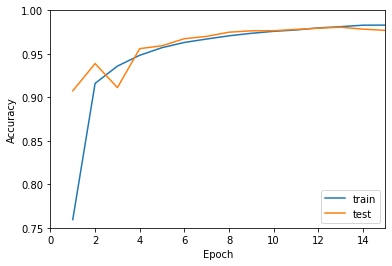

In [7]:
import matplotlib.pyplot as plt

plt.plot(np.arange(max_epoch)+1, train_accuracies, label="train")
plt.plot(np.arange(max_epoch)+1, test_accuracies, label="test")
plt.xlim(0, max_epoch)
plt.ylim(0.75, 1)
plt.legend(loc=4)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

Loss

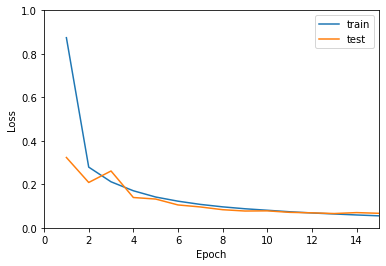

In [8]:
plt.plot(np.arange(max_epoch)+1, train_losses, label="train")
plt.plot(np.arange(max_epoch)+1, test_losses, label="test")
plt.xlim(0, max_epoch)
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()